# Title 1 Enrollment Across the Austin Area

## Hypothesis	
If Austin ISD school enrollment decreases, then the proportion of title 1 students to non title 1 students will increase

## Null	
If Austin ISD school enrollment decreases, then the proportion of title 1 students to non title 1 students will decrease or not change		

![title](AISD.jpg)

# Our Data Sources:

1. CSV files from the TEA(Texas Education Agency) website.
2. GreatSchools.org API
3. census API
4. google maps API


In [ ]:
from keys import googleKey

In [1]:
# Dependencies
import gmaps
import requests
import time
from IPython.display import display
import ipywidgets as widgets
import SchoolExplorer as se

ModuleNotFoundError: No module named 'keys'

In [ ]:
from plotly import __version__
import cufflinks as cf
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats

In [ ]:
AustinZipCo_df= pd.read_csv("csv_files/AustinPopulation.csv")
AustinDist_df = pd.read_csv("csv_files/combined.csv")

In [ ]:
c_df = pd.read_csv("csv_files/compileddata.csv")
c_df = c_df.rename(columns={'Unnamed: 0': 'Index'})

# What is Title 1?
Title I, Part A (Title I) of the Elementary and Secondary Education Act, as amended by the Every Student Succeeds Act (ESEA) provides financial assistance to local educational agencies (LEAs) and schools with high numbers or high percentages of children from low-income families to help ensure that all children meet challenging state academic standards.

# The Austin Population Heat Map

In [ ]:

# Store 'Lat' and 'Lng' into  locations 
locations = AustinZipCo_df[["LAT", "LNG"]].astype(float)

# Convert Population to float and store
# HINT: be sure to handle NaN values
population = AustinZipCo_df["Percent Population"].astype(float)
fig4 = gmaps.figure(layout={'width': '1000px','height': '1000px','border': '1px solid black','padding': '1px'})
population_layer = gmaps.heatmap_layer(locations, weights=population, 
                                 dissipating=False, max_intensity=6,
                                 point_radius = 0.05)

fig4.add_layer(population_layer)

fig4

In [ ]:
df_full = pd.read_csv('csv_files/AustinSchools.csv')
gmaps.configure(api_key=googleKey.gkey)
df = df_full[['schoolName', 'latitude', 'longitude','enrollment','type']]
df = df.rename(columns={"type":"schoolType"})
df["Percent enrollment"] = 100 * df["enrollment"] / df["enrollment"].sum()
df.fillna(0, inplace=True)
se.SchoolExplorer(df).render()

In [ ]:
df = AustinDist_df[AustinDist_df['DISTRICT NAME'].notnull()].reset_index(drop=True)

In [ ]:
#Obtains the average of masked values based on 1 percent of total enrollment
t1_missing_val = df[df['TOTAL TITLE I STUDENTS']<0]['TOTAL ENROLLMENT'].mean()*0.01
#This grabs the working dataframe columns from the orignal df, and will replace them with the t1_missing_val mean
wk_df = df[['YEAR','DISTRICT NAME','DISTRICT NUMBER','REGION','TOTAL ENROLLMENT','TOTAL TITLE I STUDENTS']]
wk_df.replace(-9999999,t1_missing_val)
wk_df['PCT_T1'] = (wk_df['TOTAL TITLE I STUDENTS'] / wk_df['TOTAL ENROLLMENT']) * 100
wk_df = wk_df.round()

In [ ]:
def yr_enrollment(limit, year='2018-2019'):
    '''Sort district ISDs by number of enrollment and academic year.
    limit: takes in an integer or float
    year: takes in a string of academic year'''
    try:
        data = wk_df[(wk_df['TOTAL ENROLLMENT'] >= limit) & 
        (wk_df['YEAR'] == year)][['DISTRICT NUMBER','DISTRICT NAME','TOTAL ENROLLMENT','TOTAL TITLE I STUDENTS']]
        data = data.sort_values('TOTAL ENROLLMENT', ascending=False).reset_index(drop=True)
        data['PCT_T1'] = (data['TOTAL TITLE I STUDENTS'] / data['TOTAL ENROLLMENT']) * 100
        return data.round()
    except Exception as e:
        return print('Please read the docsting notes')

In [ ]:
tx_enroll = df[df['YEAR']=='2018-2019']['TOTAL ENROLLMENT'].sum()
tx_t1enroll = df[df['YEAR']=='2018-2019']['TOTAL TITLE I STUDENTS'].sum()
pct_t1 = ((tx_t1enroll/tx_enroll) * 100).round()
print(f'Texas total current enrollment: {tx_enroll}.')
print(f'Texas total current title 1 enrollment: {tx_t1enroll}.')
print(f'Texas total title 1 percent enrollment: {pct_t1} percent.')

In [ ]:
yr_enrollment(65000)

In [ ]:
#names of all ISD's surrounding Austin area.
aus_area_schools = ['AUSTIN ISD','DEL VALLE ISD','DRIPPING SPRINGS ISD',
 'EANES ISD','GEORGETOWN ISD','HAYS CISD','HUTTO ISD','LAKE TRAVIS ISD',
 'LEANDER ISD','PFLUGERVILLE ISD','ROUND ROCK ISD','MANOR ISD','LAGO VISTA ISD']

In [ ]:
aus_area_df = wk_df[wk_df['DISTRICT NAME'].isin(aus_area_schools)].reset_index(drop=True)

In [ ]:
wk_plot = aus_area_df.groupby(["DISTRICT NAME", "YEAR"])['TOTAL ENROLLMENT'].mean().reset_index()

In [ ]:
#Plot enrollments of all Austin area I
wk_pivot = wk_plot.pivot(index='DISTRICT NAME', columns='YEAR')
cf.set_config_file(offline=True, world_readable=False, theme='ggplot')
wk_pivot.iplot(kind='bar',title='Autin Area ISDs')

In [ ]:
t1_plot = aus_area_df.groupby(["DISTRICT NAME", "YEAR"])['TOTAL TITLE I STUDENTS'].mean().reset_index()

In [ ]:
t1_pivot = t1_plot.pivot(index='DISTRICT NAME', columns='YEAR')
cf.set_config_file(offline=True, world_readable=False, theme='ggplot')
t1_pivot.iplot(kind='bar',title='Autin Area ISDs Title 1 Status')

In [ ]:
t1_pct_plot = aus_area_df.groupby(["DISTRICT NAME", "YEAR"])['PCT_T1'].mean().reset_index()

In [ ]:
t1_pct_pivot = t1_pct_plot.pivot(index='DISTRICT NAME', columns='YEAR')
cf.set_config_file(offline=True, world_readable=False, theme='ggplot')
t1_pct_pivot.iplot(kind='bar',title='Autin Area ISDs Title 1 Pecent Status')

In [ ]:
# title one vs. non-title one
# Calculate proportion of title one to non-title one students
c_df['non_title1'] = c_df['total_enroll']- c_df['total_title1']
non_t1 = c_df[['year', 'total_title1', 'non_title1']]
non_t1_sum = non_t1.groupby('year').sum()

non_df = non_t1_sum.reset_index()
non_df['Percentage'] = (non_df['non_title1']/non_df['total_title1'])*100
non_df['Ratio'] = (100/non_df['Percentage'])
non_df['T1_rate_of_change'] = (non_df.iloc[0,1]-non_df['total_title1'])*(-1)
non_df['n-T1_rate_of_change'] = (non_df.iloc[0,2]-non_df['non_title1'])*(-1)
non_df['n-T1_negatvie_rate_of_change'] = (non_df.iloc[0,2]-non_df['non_title1'])
rate_enr_t1 = non_df[['year', 'T1_rate_of_change', 'n-T1_negatvie_rate_of_change']]
non_df

df_nnn = non_df[['year','Ratio']].set_index('year')
df_nnn.iplot(kind='line', yTitle='Ratio Title One to Non-Title One', xTitle='Years', title="Title One to Non-Title One Ratio")

In [ ]:
# group by data
# year
year_df = c_df.groupby('year').sum()
# year and school type
year_type_df = c_df.groupby(['school_type', 'year']).sum()
year_df
# Caclulate and pull out column for percentage of title one students per year
year_type_df['T1_rate'] = (year_type_df['total_title1']/year_type_df['total_enroll'])*100
year_type_df
df_s = year_type_df['T1_rate']
df_s.head()

df_s.unstack().iplot(kind='bar', yTitle='Title One Student Enrollment (%)', xTitle='School Type', title="Title One Student Percentage by School Type")

In [ ]:
# find the top 5 populate high schools
high_ind = c_df.set_index('school_type')
high = high_ind.loc['High'].groupby(['year', 'campus']).sum()
labels=["Bowie High School","Akins High School","Anderson High School","Austin High School","Mccallum High School"]
high_t1 = pd.DataFrame(high[['total_title1', 'total_enroll']]).reset_index()
high_t1['title1_%'] = (high_t1['total_title1']/high_t1['total_enroll'])*100
top_high = high_t1.set_index('campus')
top_high = top_high[['title1_%', 'year']]
top_5 = top_high.loc[["Bowie High School","Akins High School","Anderson High School","Austin High School","Mccallum High School"]]
top_5 = top_5.groupby(['campus', 'year']).sum()
top_5.head()
top_5.unstack().iplot(kind='bar', yTitle='Student Enrollment', xTitle='Campus Name', title="Student Enrollment Overview")

In [3]:
%store -r df
df.head()

,name,type,14-16 Percent Title I Change,14-16 Total Enrollment Change,15-17 Percent Title I Change,15-17 Total Enrollment Change,16-18 Percent Title I Change,16-18 Total Enrollment Change
0,AKINS H S,public,284.281071,46.0,-31.727699,-33.0,47.059924,85.0
1,ALLISON EL,public,0.000000,58.0,0.000000,-85.0,0.000000,19.0
2,ANDERSON H S,public,42.507008,46.0,-29.606450,-53.0,117.690860,5.0
3,ANDREWS EL,public,0.000000,-63.0,0.000000,-22.0,0.000000,-68.0
4,AUSTIN H S,public,36.429070,-1.0,-35.229215,61.0,108.160565,122.0


In [10]:
%store -r firstR
print("14-16 Results", firstR, sep='\n\n')

14-16 Results

LinregressResult(slope=-0.8559449607655654, intercept=383.44351497749466, rvalue=-0.014640106766023188, pvalue=0.8804631468374476, stderr=5.678087962438074)


In [11]:
%store -r secondR
print("15-17 Results", secondR, sep='\n\n')

15-17 Results

LinregressResult(slope=0.6710295889902052, intercept=28.304865870518164, rvalue=0.1242204220421749, pvalue=0.20023499103991366, stderr=0.5206176406570172)


In [12]:
%store -r thirdR
print("16-18 Results", secondR, sep='\n\n')

16-18 Results

LinregressResult(slope=0.6710295889902052, intercept=28.304865870518164, rvalue=0.1242204220421749, pvalue=0.20023499103991366, stderr=0.5206176406570172)


In [15]:
%store -r ethnicity_total_df
ethnicity_total_df.head()

,name,2014-2015 TOTAL TITLE I STUDENTS,2015-2016 TOTAL TITLE I STUDENTS,2016-2017 TOTAL TITLE I STUDENTS,2017-2018 TOTAL TITLE I STUDENTS,"White, non-Hispanic","Black, non-Hispanic",Hispanic,Multiracial,Asian,Native American or Native Alaskan,Native Hawaiian or Other Pacific Islander,Major Ethnicity
0,AKINS H S,11.0,43.0,29.0,44.0,10.50,8.18,76.82,1.51,2.80,0.07,0.11,Hispanic
1,ALLISON EL,487.0,545.0,460.0,479.0,0.55,4.04,95.23,0.00,0.00,0.18,0.00,Hispanic
2,ANDERSON H S,11.0,16.0,11.0,24.0,50.84,5.90,32.11,3.83,7.09,0.18,0.04,"White, non-Hispanic"
3,ANDREWS EL,657.0,594.0,572.0,504.0,3.70,13.47,79.97,0.17,2.53,0.17,0.00,Hispanic
4,AUSTIN H S,11.0,15.0,10.0,22.0,45.92,4.80,44.19,2.98,1.92,0.10,0.10,Other


NameError: name 'plt' is not defined

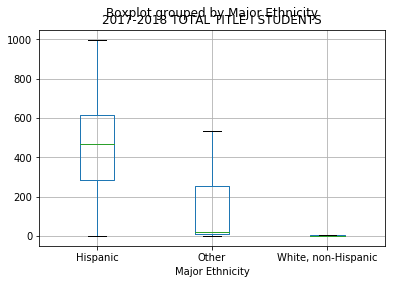

In [16]:
ethnicity_total_df.boxplot("2017-2018 TOTAL TITLE I STUDENTS", by="Major Ethnicity", showfliers=False)
plt.suptitle("")
plt.title('Boxplot by Major Ethnicity')
plt.plot()

In [17]:
stats.ttest_ind(hispanic_pop['2017-2018 TOTAL TITLE I STUDENTS'], white_non_h_pop['2017-2018 TOTAL TITLE I STUDENTS'], equal_var=False)

NameError: name 'stats' is not defined